# Interpretación de música de piano usando técnicas de Deep Learning.
## Trabajo de Fin de Grado.
### Facultad de Ciencias - Universidad de Cantabria.
**Autor:** Álvaro López García. <br>
**Tutor:** Cristina Tirnauca.

In [ ]:
# Colab-only
from google.colab import drive
drive.mount('/content/drive')
!pip install mido
%cd drive/MyDrive/Colab\ Notebooks/TFG/

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 4.5 MB/s 
/content/drive/MyDrive/Colab Notebooks/TFG


In [2]:
# Celda para importar librerías, costantes, etc.
import tensorflow as tf
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import gc
import mido
import math
import copy

from matplotlib import pyplot as plt
from IPython import display
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Para entrenarlo en mi equipor personal / colab:
PATH = '/Volumes/TheVault/Documentos Mac/Documentos Universidad/4o Curso/2o Cuatrimestre/Trabajo de Fin de Grado/maestro-v3.0.0/'
#PATH = '../maestro-v3.0.0/'

### Creación del dataframe

In [3]:
def get_dataframe(path=PATH + 'maestro-v3.0.0.csv'):
    return pd.read_csv(path)

def set_dataframe(df, path=PATH + 'maestro-v3.0.0.csv'):
    df.to_csv(path, index=False)

In [4]:
df = get_dataframe('maestro-v3.0.0.csv')
df.head()

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,epochs_trained
0,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433,100
1,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588,100
2,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508,100
3,Alexander Scriabin,"5 Preludes, Op.15",validation,2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826,100
4,Alexander Scriabin,"Entragete, Op.63",test,2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830,0


## Clases, métodos y constantes para el procesado del Dataset

### Parámetros del procesado

In [5]:
#Parámetros de configuración de los archivos de audio
SAMPLING_RATE = 16000
N_NOTES = 88

###  Código para el procesado de los datos relativos a los ficheros MIDI (`*.midi -> tf.Dataset`)

In [6]:
# Constantes relativas al estádar MIDI
DEFAULT_SR = 500000

In [7]:
from utils.midi_handler import Midi_handler
midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)

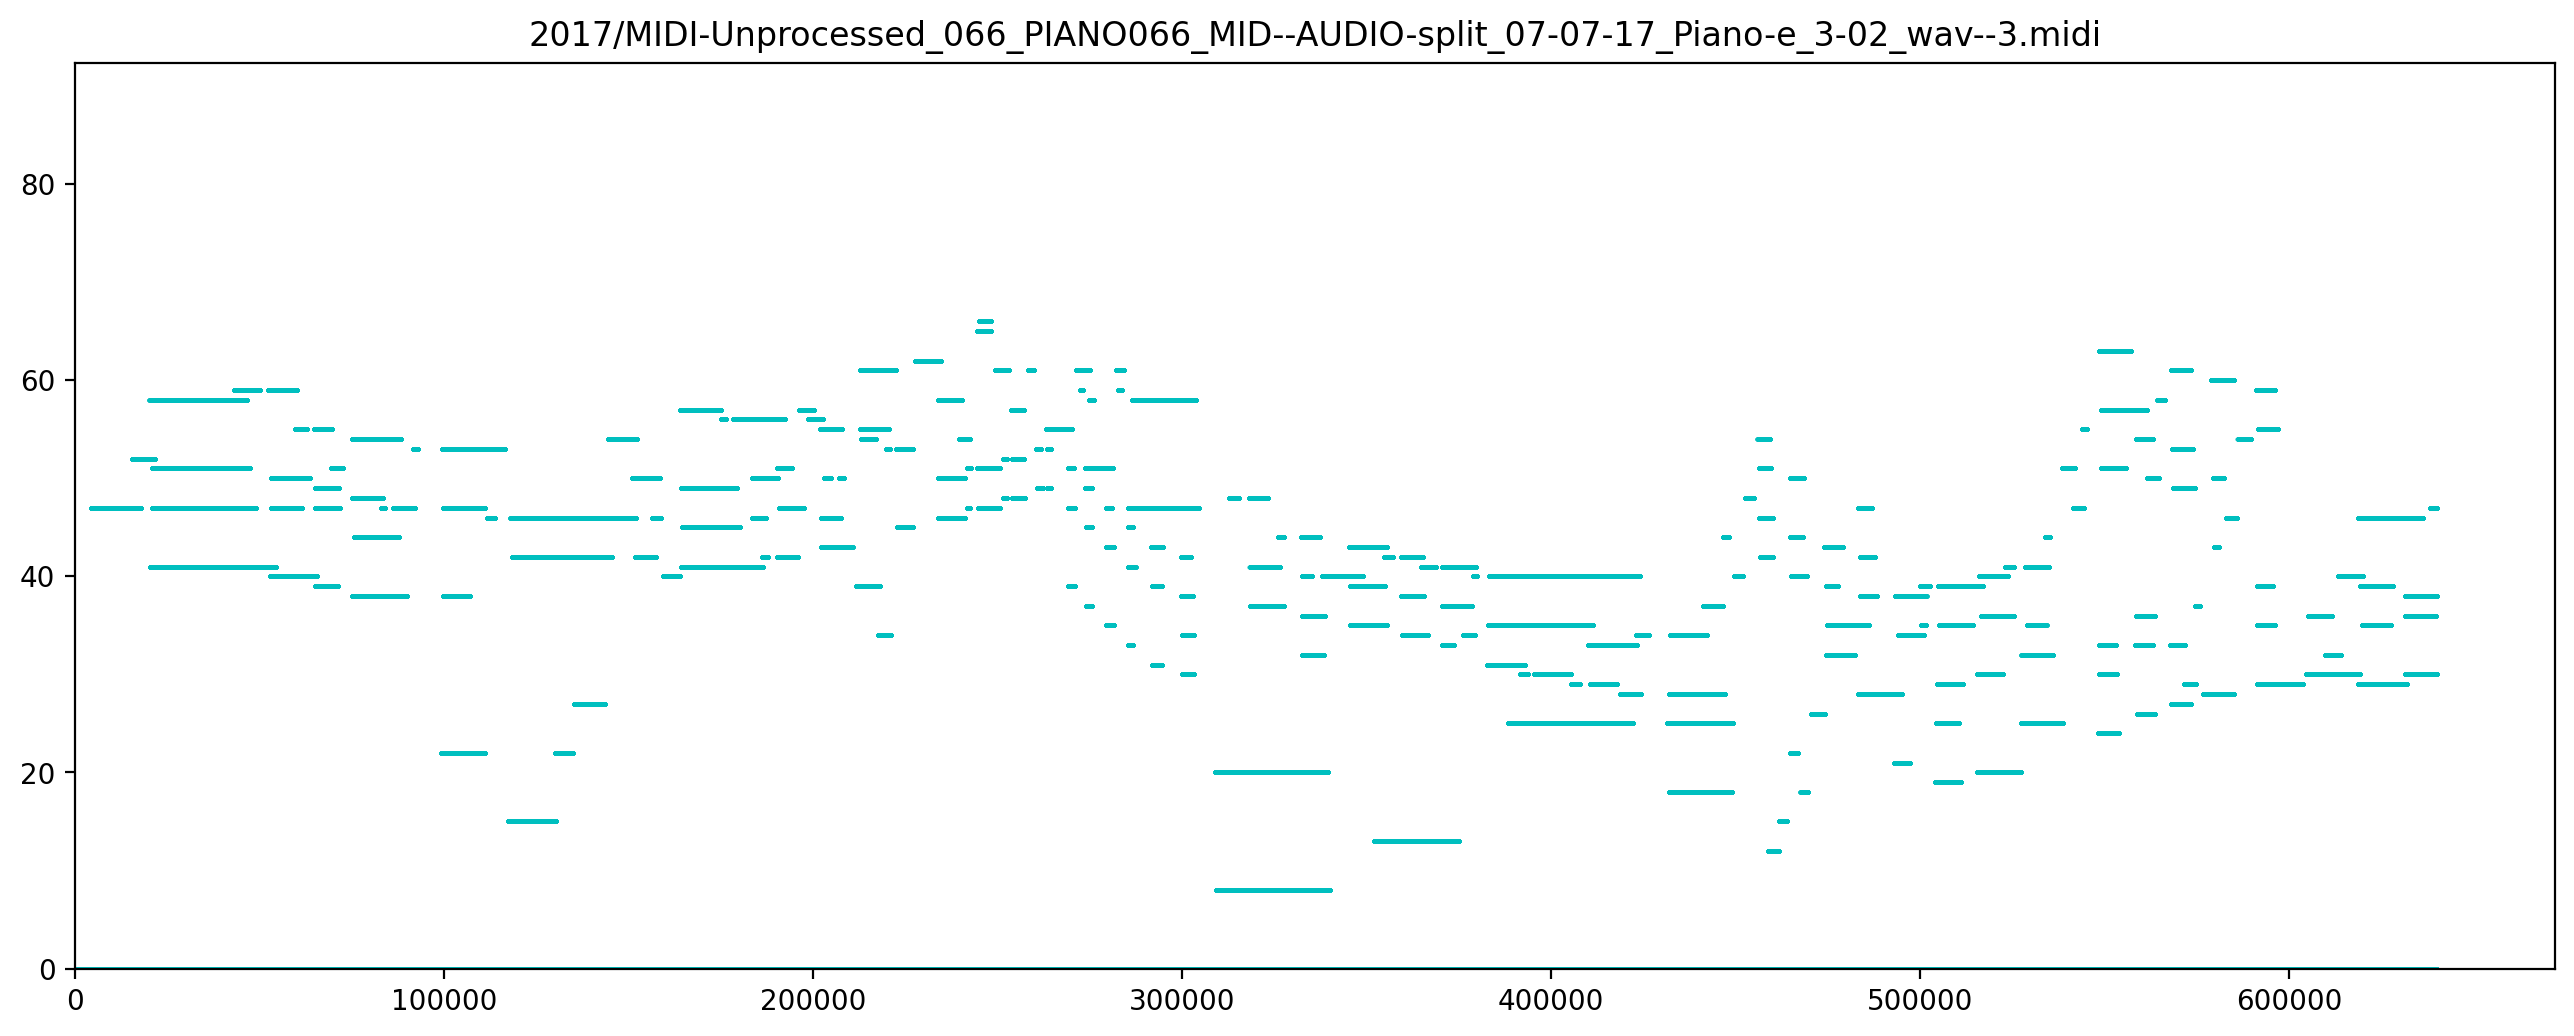

In [ ]:
# Ploteamos una sección de un pianoroll de ejemplo
midi_hdlr.plot_pianoroll(midi_hdlr.vectorize_midi(df['midi_filename'][0])[0:640000], title=df['midi_filename'][0])

Para los datos relativos a los ficheros `.midi` aplicaremos la normalización **MinMax** donde cada nuevo valor $x'$ para cada ejemplo $x$ vendrá dado por: $$ x' = \frac{x - min}{max - min} ,$$ donde $max$ y $min$ son los valores máximos y mínimos de los valores de entrada. En este caso, dada la definición del estándar MIDI, sabemos que los valores de estas velocidades ya están parametrizados entre $0$ y $127$ por lo que no necesitamos iterar sobre los datos para conocer el máximo y el mínimo. Para ello definiremos las siguientes constantes:

In [8]:
# Constates para aplicar la normalización a los ficheros MIDI
MIDI_MAX = 127
MIDI_MIN = 0

### Código para el procesado de los datos relativos a los ficheros de audio (`*.wav -> tf.Dataset`)

In [9]:
from utils.wav_handler import Wav_handler
wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)

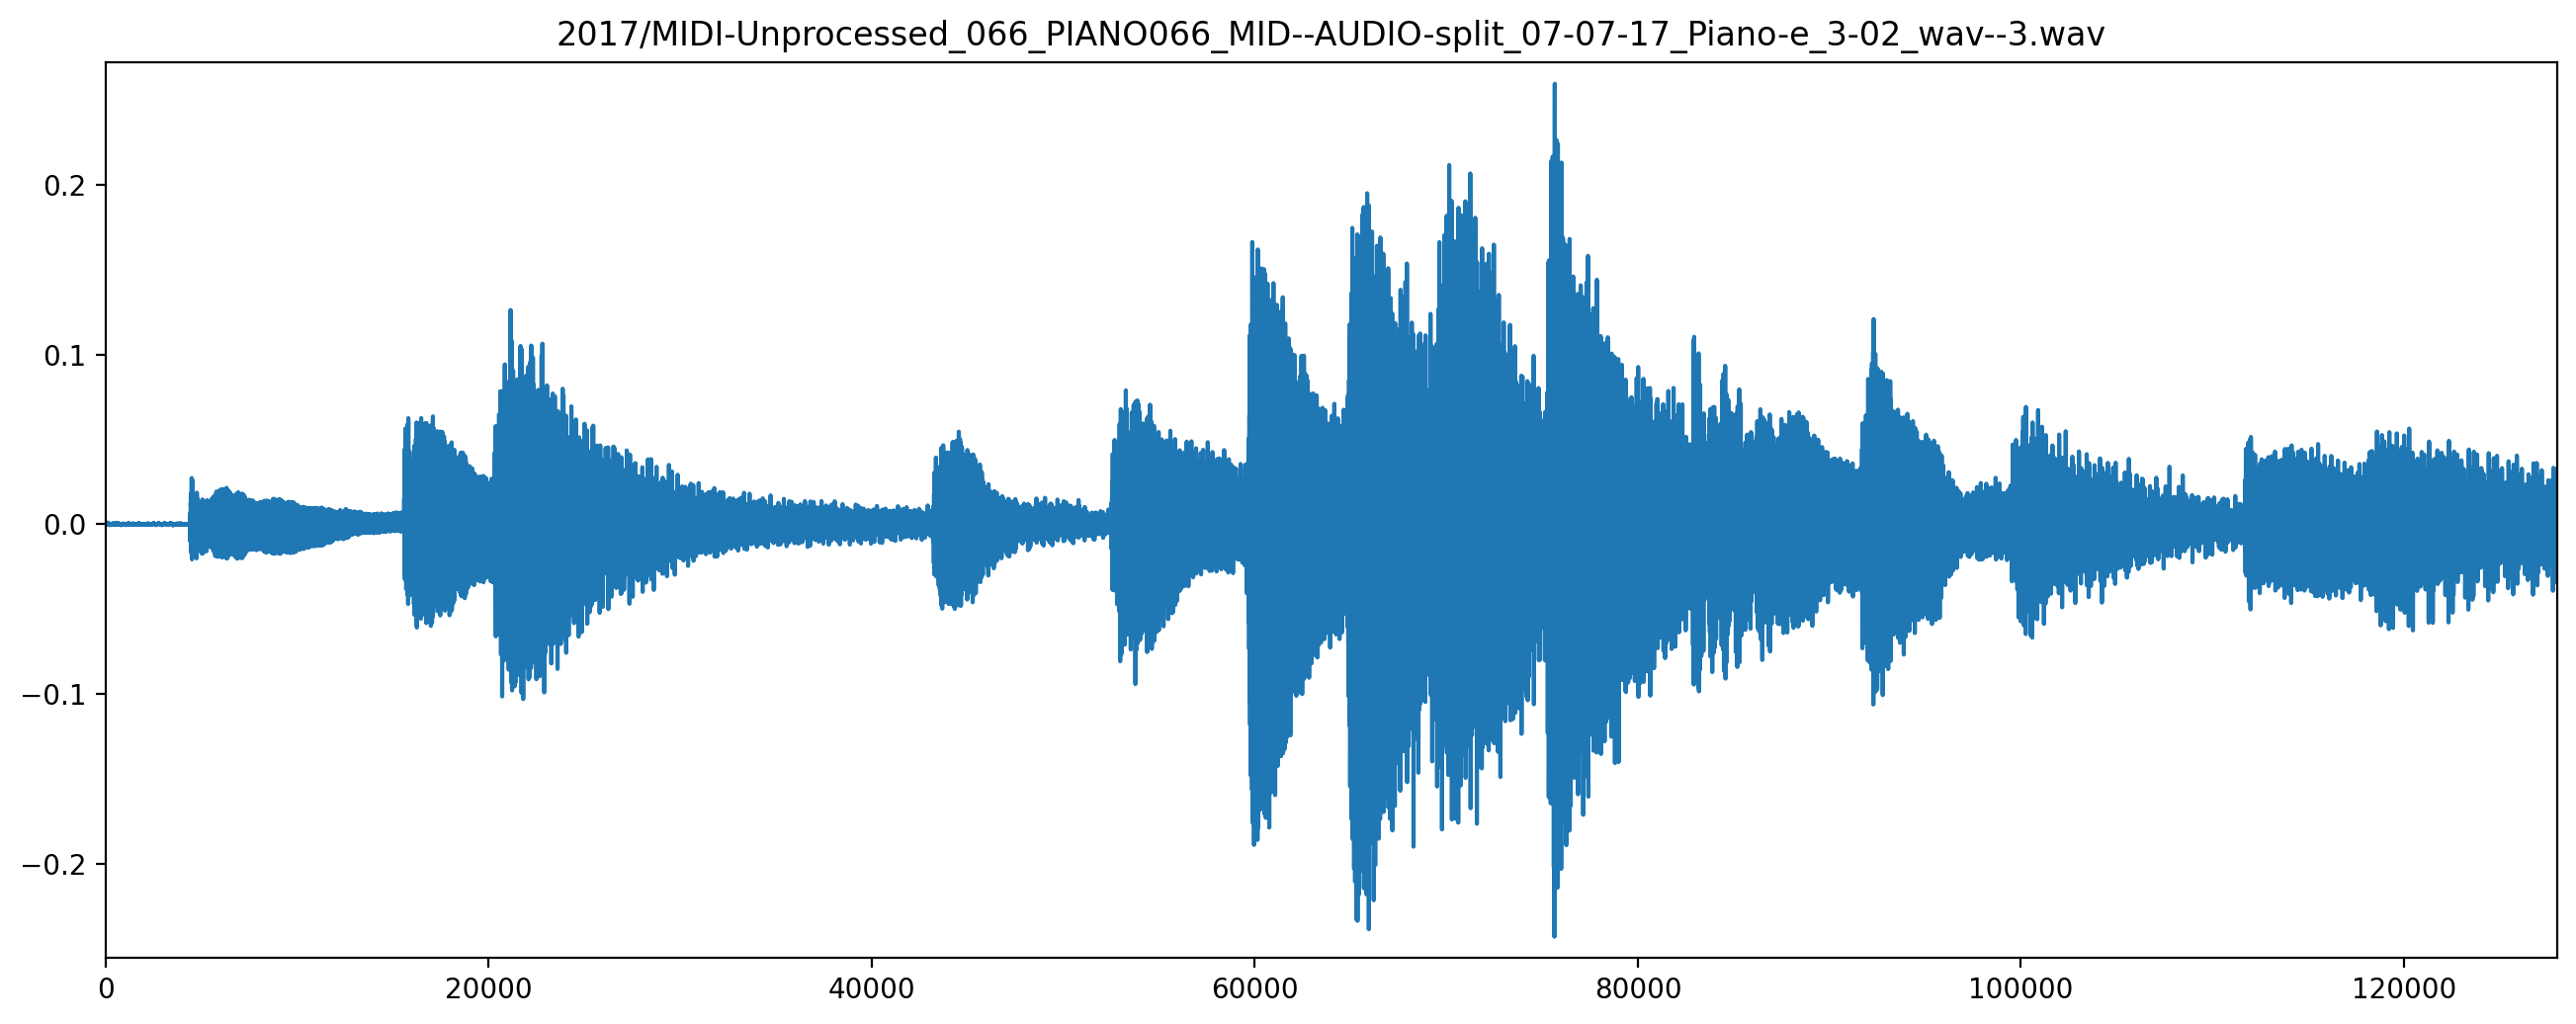

In [ ]:
# Ploteamos una sección de una onda
wav_hdlr.plot_wav(wav_hdlr.vectorize_wav(df['audio_filename'][0])[0:128000], title=df['audio_filename'][0])

Para la compresión de la señal emplearemos una compresión basada en una $\mu$-law.

In [10]:
# Constates relativas a la compresión con la mu-law
N_BITS = 7
N_LEVELS = 2 ** N_BITS
MU = 256
AMPS = (-1, 1)

In [11]:
from utils.mu_law_encoder import Mu_law_encoder
mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

## Creación del modelo
![Wavenet](resources/WaveNet_residblock.png)

In [12]:
def calculate_receptive_field(n_blocks, n_layers):
    return sum([2 ** i for i in range(n_layers)] * n_blocks) - n_blocks + 1

In [13]:
# Parámetros que definen la arquitectura del modelo a crear por defecto en las llamadas a get_wavenet()

# Parámetros de la arquitectura interna de la red
N_FILTERS = N_LEVELS
FILTER_WIDTH = 2

# Main wavenet
N_BLOCKS = 6
K_LAYERS = 7

# Context stack
CONTEXT_BLOCKS = 2
CONTEXT_LAYERS = 6

# Números y longitudes de ejemplos de entrada, salida y local conditioning
INPUT_LEN = calculate_receptive_field(N_BLOCKS, K_LAYERS)
N_IN_CHANNELS = N_LEVELS
LC_LEN = 1
N_LC_CHANNELS = N_NOTES

# Dimensionalidad de input/output/local conditioning
INP_SHAPE = (INPUT_LEN, N_IN_CHANNELS)
OUT_SHAPE = INP_SHAPE
LC_SHAPE = (LC_LEN, N_LC_CHANNELS)

In [14]:
'''
    Método que devuelve el modelo de una WaveNet implementada en tensorflow. Dicha red se construye 
    de acuerdo a los parámetros de entrada.
'''
def get_wavenet(inp_shape=INP_SHAPE, out_shape=OUT_SHAPE, lc_shape=LC_SHAPE, n_filters=N_FILTERS,
                filter_width=FILTER_WIDTH, k_layers=K_LAYERS, n_blocks=N_BLOCKS, 
                context_layers=CONTEXT_LAYERS, context_blocks=CONTEXT_BLOCKS):
    
    # Skip connections
    skips = []
    
    # Dilation rates
    dilations_per_block = [2 ** i for i in range(k_layers)] * n_blocks
    dilations_per_ctx_block = [2 ** i for i in range(context_layers)] * context_blocks
    
    # Local Conditioning
    Input_lc = tf.keras.layers.Input(shape=lc_shape, dtype='float32', name='lc')
    lc = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal')(Input_lc)
    
    # Context stack
    for dilation_rate in dilations_per_ctx_block:
        
        # Convolución y gated activation
        lc_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal',
                                        dilation_rate=dilation_rate)(lc)
        gated_act = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(lc),
                                        tf.keras.layers.Activation('sigmoid')(lc)])
        gated_act = tf.keras.layers.Conv1D(1, 1, padding='same')(gated_act)
        
        # Residual connection
        lc = tf.keras.layers.Add()([lc, gated_act])
    
    # Input
    Input_seq = tf.keras.layers.Input(shape=inp_shape, dtype='float32', name='seq')
    seq = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal')(Input_seq) 

    for dilation_rate in dilations_per_block:

        # Sumamos la información del local conditioning a la convolución de los valores de audio
        seq_conv = tf.keras.layers.Conv1D(n_filters, filter_width, padding='causal',
                                        dilation_rate=dilation_rate)(seq)
        tmp = tf.keras.layers.Add()([seq_conv, lc])
        
        # Gated activation
        gated_act = tf.keras.layers.Multiply()([tf.keras.layers.Activation('tanh')(tmp),
                                        tf.keras.layers.Activation('sigmoid')(tmp)])

        gated_act = tf.keras.layers.Conv1D(1, 1, padding='same')(gated_act)

        # Residual connection
        seq = tf.keras.layers.Add()([seq, gated_act])    

        # Vamos añadiendo las 'Skip conections'
        skips.append(gated_act)

    # Sumamos todas las skip connections y computamos el resto de funciones
    out = tf.keras.layers.Add()(skips)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(1, 1, padding='same')(out)
    out = tf.keras.layers.ReLU()(out)
    out = tf.keras.layers.Conv1D(out_shape[1], 1, padding='same')(out)
    out = tf.keras.layers.Softmax()(out)
    return tf.keras.models.Model(inputs=[Input_seq, Input_lc], outputs=out)

model = get_wavenet()
model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-09-05 21:49:22.999904: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1, 128)       22656       ['lc[0][0]']                     
                                                                                                  
 activation (Activation)        (None, 1, 128)       0           ['conv1d[0][0]']                 
                                                                                                  
 activation_1 (Activation)      (None, 1, 128)       0           ['conv1d[0][0]']                 
                                                                                              

 multiply_6 (Multiply)          (None, 1, 128)       0           ['activation_12[0][0]',          
                                                                  'activation_13[0][0]']          
                                                                                                  
 conv1d_14 (Conv1D)             (None, 1, 1)         129         ['multiply_6[0][0]']             
                                                                                                  
 add_6 (Add)                    (None, 1, 128)       0           ['add_5[0][0]',                  
                                                                  'conv1d_14[0][0]']              
                                                                                                  
 activation_14 (Activation)     (None, 1, 128)       0           ['add_6[0][0]']                  
                                                                                                  
 activatio

                                                                                                  
 conv1d_27 (Conv1D)             (None, 757, 1)       129         ['multiply_12[0][0]']            
                                                                                                  
 add_13 (Add)                   (None, 757, 128)     0           ['conv1d_25[0][0]',              
                                                                  'conv1d_27[0][0]']              
                                                                                                  
 conv1d_28 (Conv1D)             (None, 757, 128)     32896       ['add_13[0][0]']                 
                                                                                                  
 add_14 (Add)                   (None, 757, 128)     0           ['conv1d_28[0][0]',              
                                                                  'add_11[0][0]']                 
          

 multiply_17 (Multiply)         (None, 757, 128)     0           ['activation_34[0][0]',          
                                                                  'activation_35[0][0]']          
                                                                                                  
 conv1d_37 (Conv1D)             (None, 757, 1)       129         ['multiply_17[0][0]']            
                                                                                                  
 add_23 (Add)                   (None, 757, 128)     0           ['add_21[0][0]',                 
                                                                  'conv1d_37[0][0]']              
                                                                                                  
 conv1d_38 (Conv1D)             (None, 757, 128)     32896       ['add_23[0][0]']                 
                                                                                                  
 add_24 (A

 activation_45 (Activation)     (None, 757, 128)     0           ['add_32[0][0]']                 
                                                                                                  
 multiply_22 (Multiply)         (None, 757, 128)     0           ['activation_44[0][0]',          
                                                                  'activation_45[0][0]']          
                                                                                                  
 conv1d_47 (Conv1D)             (None, 757, 1)       129         ['multiply_22[0][0]']            
                                                                                                  
 add_33 (Add)                   (None, 757, 128)     0           ['add_31[0][0]',                 
                                                                  'conv1d_47[0][0]']              
                                                                                                  
 conv1d_48

 activation_54 (Activation)     (None, 757, 128)     0           ['add_42[0][0]']                 
                                                                                                  
 activation_55 (Activation)     (None, 757, 128)     0           ['add_42[0][0]']                 
                                                                                                  
 multiply_27 (Multiply)         (None, 757, 128)     0           ['activation_54[0][0]',          
                                                                  'activation_55[0][0]']          
                                                                                                  
 conv1d_57 (Conv1D)             (None, 757, 1)       129         ['multiply_27[0][0]']            
                                                                                                  
 add_43 (Add)                   (None, 757, 128)     0           ['add_41[0][0]',                 
          

                                                                  'add_11[0][0]']                 
                                                                                                  
 activation_64 (Activation)     (None, 757, 128)     0           ['add_52[0][0]']                 
                                                                                                  
 activation_65 (Activation)     (None, 757, 128)     0           ['add_52[0][0]']                 
                                                                                                  
 multiply_32 (Multiply)         (None, 757, 128)     0           ['activation_64[0][0]',          
                                                                  'activation_65[0][0]']          
                                                                                                  
 conv1d_67 (Conv1D)             (None, 757, 1)       129         ['multiply_32[0][0]']            
          

                                                                                                  
 add_62 (Add)                   (None, 757, 128)     0           ['conv1d_76[0][0]',              
                                                                  'add_11[0][0]']                 
                                                                                                  
 activation_74 (Activation)     (None, 757, 128)     0           ['add_62[0][0]']                 
                                                                                                  
 activation_75 (Activation)     (None, 757, 128)     0           ['add_62[0][0]']                 
                                                                                                  
 multiply_37 (Multiply)         (None, 757, 128)     0           ['activation_74[0][0]',          
                                                                  'activation_75[0][0]']          
          

                                                                                                  
 conv1d_86 (Conv1D)             (None, 757, 128)     32896       ['add_71[0][0]']                 
                                                                                                  
 add_72 (Add)                   (None, 757, 128)     0           ['conv1d_86[0][0]',              
                                                                  'add_11[0][0]']                 
                                                                                                  
 activation_84 (Activation)     (None, 757, 128)     0           ['add_72[0][0]']                 
                                                                                                  
 activation_85 (Activation)     (None, 757, 128)     0           ['add_72[0][0]']                 
                                                                                                  
 multiply_

 add_81 (Add)                   (None, 757, 128)     0           ['add_79[0][0]',                 
                                                                  'conv1d_95[0][0]']              
                                                                                                  
 conv1d_96 (Conv1D)             (None, 757, 128)     32896       ['add_81[0][0]']                 
                                                                                                  
 add_82 (Add)                   (None, 757, 128)     0           ['conv1d_96[0][0]',              
                                                                  'add_11[0][0]']                 
                                                                                                  
 activation_94 (Activation)     (None, 757, 128)     0           ['add_82[0][0]']                 
                                                                                                  
 activatio

 conv1d_105 (Conv1D)            (None, 757, 1)       129         ['multiply_51[0][0]']            
                                                                                                  
 add_91 (Add)                   (None, 757, 128)     0           ['add_89[0][0]',                 
                                                                  'conv1d_105[0][0]']             
                                                                                                  
 conv1d_106 (Conv1D)            (None, 757, 128)     32896       ['add_91[0][0]']                 
                                                                                                  
 add_92 (Add)                   (None, 757, 128)     0           ['conv1d_106[0][0]',             
                                                                  'add_11[0][0]']                 
                                                                                                  
 activatio

 re_lu_1 (ReLU)                 (None, 757, 1)       0           ['conv1d_110[0][0]']             
                                                                                                  
 conv1d_111 (Conv1D)            (None, 757, 128)     256         ['re_lu_1[0][0]']                
                                                                                                  
 softmax (Softmax)              (None, 757, 128)     0           ['conv1d_111[0][0]']             
                                                                                                  
Total params: 1,444,408
Trainable params: 1,444,408
Non-trainable params: 0
__________________________________________________________________________________________________


### Obtenemos los datos y los transformamos los datos a los que acepta el modelo

In [15]:
# Parámetros de entrenamiento
N_EPOCHS = 100
BATCH_SIZE = 25

# Parámetros para ajustar el tiempo de entrenamiento
DIM_FACTOR = (10 * 24 * 60)/(90 * len(df) * N_EPOCHS)

FIRST_ITEM = int(1.25 * SAMPLING_RATE) # Comenzamos en el segundo 1.25, el comienzo de la obra en promedio
LAST_ITEM = FIRST_ITEM + int(min(df['duration']) * SAMPLING_RATE * DIM_FACTOR)
FILE_LENGTH = FIRST_ITEM + int(2 * min(df['duration']) * SAMPLING_RATE * DIM_FACTOR)

In [16]:
feature_description = {
    "lc": tf.io.FixedLenFeature(shape=[np.prod(LC_SHAPE[1])], dtype=tf.float32),
    "seq": tf.io.FixedLenFeature(shape=[np.prod(INP_SHAPE[0])], dtype=tf.int64),
    "out": tf.io.FixedLenFeature(shape=[np.prod(OUT_SHAPE[0])], dtype=tf.int64)}

def parse_sample(sample):
    return tf.io.parse_single_example(sample, features=feature_description)

def midi_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.flatten()))

def wav_feature(value, mulaw_enc):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=mulaw_enc.encode_series(value).flatten()))

def generate_data(df):
    
    # Para procesar los ficheros
    midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)
    wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)

    # Para aplicar el mu-law encoding
    mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

    midi_data = (midi_hdlr.vectorize_midi(df['midi_filename']) - MIDI_MIN) / (MIDI_MAX - MIDI_MIN)
    wav_data = wav_hdlr.vectorize_wav(df['audio_filename'])

    length = min([len(midi_data), len(wav_data)]) - INPUT_LEN
    print(f"Thread {threading.get_ident()} escribiendo")

    for idx, (midi_, wav_) in enumerate(zip(midi_data, wav_data)):
        if idx >= FILE_LENGTH: break
        feature = {"lc": midi_feature(midi_data[idx+INPUT_LEN]),
                "seq": wav_feature(wav_data[idx:idx+INPUT_LEN], mulaw_enc),
                "out": wav_feature(wav_data[idx+1:idx+INPUT_LEN+1], mulaw_enc)}

        yield tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

def write_data(df, max_files=None, max_samples=None, file='cache_out'):

    assert(file is not None)
    assert(max_samples is None or max_samples > INPUT_LEN)
    assert(max_files is None or max_files > 0)

    # Calculamos el número máximo de ficheros y ejemplos por fichero
    num_files = -1 if max_files is None else max_files
    num_samples = -1 if max_samples is None else max_samples
    
    serialized_features_dataset = tf.data.Dataset.from_generator(lambda : generate_data(df),
                    output_types=tf.string, output_shapes=())
        
    tf.data.experimental.save(serialized_features_dataset, file, compression='GZIP')

def read_data(filename=None):
    assert(filename is not None)
    return  tf.data.experimental.load(filename, compression='GZIP')

In [ ]:
import queue
import threading
import time

class myThread(threading.Thread):

    def __init__(self, threadID, name, q):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.q = q

    def run(self):
        print(f"Levantando {self.name}...")
        process_data(self.name, self.q)
        print(f"... terminando {self.name}")

def process_data(threadName, q):
    while not exitFlag:
        queueLock.acquire()
        if not workQueue.empty():
            data = q.get()
            queueLock.release()
            print(f"{threadName} processing {data}\n")
            idx, split, midi, wav = data
            cache_file = 'cache/' + split + '/' + midi[:-5]
            write_data(df.iloc[idx], file=cache_file)
            print(f"{threadName} termina un fichero\n")
        else:
            queueLock.release()
            time.sleep(1)

In [ ]:
N_THREADS = 4

exitFlag = False
queueLock = threading.Lock()
workQueue = queue.Queue(len(df))

threads = []

# Fill the queue
queueLock.acquire()
for idx, (split, midi, wav) in enumerate(zip(df['split'], df['midi_filename'], 
                                                 df['audio_filename'])):
    workQueue.put((idx, split, midi, wav))
queueLock.release()

# Create new threads
for i in range(N_THREADS):
    thread = myThread(i, f"Thread {i}", workQueue)
    thread.start()
    threads.append(thread)

# Wait for queue to empty
while not workQueue.empty():
    time.sleep(10)

# Notify threads it's time to exit
exitFlag = True

# Wait for all threads to complete
for t in threads:
    t.join()
print("Exiting Main Thread")

### Loop de entrenamiento

In [27]:
try:
    model = tf.keras.models.load_model('model.hdf5')
    print("Cargado modelo anterior")
except:
    model = get_wavenet()
    model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Creando nuevo modelo")
    
# Para procesar los ficheros
midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)
wav_hdlr = Wav_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH)

# Para aplicar el mu-law encoding
mulaw_enc = Mu_law_encoder(mu=MU, n_bits=N_BITS, amps=AMPS)

# Obtenemos el epoch actual
current_epoch = min(df[(df['split'] == 'validation') | 
                    (df['split'] == 'train')]['epochs_trained'])

print(f'Comenzando el entrenamiento del modelo (nº de epochs: {N_EPOCHS}, parámetros a entrenar: {np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])})...')
print('------------------------------------------------------------------------')

while current_epoch < N_EPOCHS:

    # Obtenemos los ficheros a entrenar en este epoch
    train_df = df[(df['epochs_trained'] <= current_epoch) & 
                                    (df['split'] == 'train')]
    
    print(f'Comenzando epoch nº {current_epoch}...')
    
    # Para cada fichero entrenamos
    for idx, split, midi in zip(train_df.index, train_df['split'], train_df['midi_filename']):
        
        print(f'Entrenando el fichero {midi[:-5]}...')

        dataset = read_data('cache/' + train_df.loc[idx, 'split'] + '/' +
                            train_df.loc[idx, 'midi_filename'][:-5])
        dataset = dataset.map(lambda x: parse_sample(x))
        dataset = dataset.map(lambda x: ({'lc': tf.expand_dims(x['lc'], 0),
                                 'seq': tf.one_hot(x['seq'], depth=N_LEVELS)},
                                 tf.one_hot(x['out'], depth=N_LEVELS)),
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        # Calculamos la longitud
        length = int((LAST_ITEM - FIRST_ITEM) / BATCH_SIZE)

        # Callbacks
        train_acc_logger = tf.keras.callbacks.CSVLogger('training_accuracy.csv', separator=",", append=True)
        best_checkpoint = tf.keras.callbacks.ModelCheckpoint("best.hdf5", monitor='accuracy', 
                                                             save_best_only=True, mode='max')

        # Entrenamos
        model.fit(dataset, steps_per_epoch=length, epochs=1,\
                            callbacks=[train_acc_logger, best_checkpoint],\
                            use_multiprocessing=True)
        
        # Guardamos el modelo
        model.save('model.hdf5')
        
        # Actualizamos el csv con el progreso del entrenamiento
        df.loc[df['midi_filename'] == midi, 'epochs_trained'] = current_epoch + 1
        set_dataframe(df, path='maestro-v3.0.0.csv')

        # Manual garbage collection
        del dataset

    # Obtenemos los valores de cross validation
    crossval_df = df[(df['epochs_trained'] <= current_epoch) &
                      (df['split'] == 'validation')]

    print('Calculando pérdida para el conjunto de cross validation...')
    
    # Para cada fichero medimos la cross validation score al final del epoch
    for idx, split, midi in zip(crossval_df.index, crossval_df['split'], crossval_df['midi_filename']):
        
        print(f'Calculando pérdida para el fichero {midi[:-5]}...')
        
        dataset = read_data('cache/' + crossval_df.loc[idx, 'split'] + '/' +
                         crossval_df.loc[idx, 'midi_filename'][:-5])
        dataset = dataset.map(lambda x: parse_sample(x))
        dataset = dataset.map(lambda x: ({'lc': tf.expand_dims(x['lc'], 0),
                                 'seq': tf.one_hot(x['seq'], depth=N_LEVELS)},
                                 tf.one_hot(x['out'], depth=N_LEVELS)),
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        # Calculamos la longitud
        length = int((LAST_ITEM - FIRST_ITEM) / BATCH_SIZE)
        
        # Callback
        # Lineas para que el callback funcione con model.evaluate()
        cv_acc_logger = tf.keras.callbacks.CSVLogger('crossval_accuracy.csv', separator=",", append=True)
        cv_acc_logger.on_test_begin = cv_acc_logger.on_train_begin
        cv_acc_logger.on_test_batch_end = cv_acc_logger.on_epoch_end
        cv_acc_logger.on_test_end = cv_acc_logger.on_train_end
        
        # Calculamos la pedida
        model.evaluate(dataset, steps=length, use_multiprocessing=True,\
                                    callbacks=[cv_acc_logger])
        
        # Actualizamos el csv con el progreso del entrenamiento
        df.loc[df['midi_filename'] == midi, 'epochs_trained'] = current_epoch + 1
        set_dataframe(df, path='maestro-v3.0.0.csv')
        
        # Manual garbage collection
        del dataset
    
    current_epoch += 1
    
print('------------------------------------------------------------------------')

Se han truncado las últimas 5000 líneas del flujo de salida.
Entrenando el fichero 2009/MIDI-Unprocessed_04_R1_2009_01-03_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_02_WAV...
65/65 [==============================] - 10s 148ms/step - loss: 4.1644 - accuracy: 0.0293
Entrenando el fichero 2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1...
65/65 [==============================] - 10s 152ms/step - loss: 2.7035 - accuracy: 0.1123
Entrenando el fichero 2015/MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--3...
65/65 [==============================] - 10s 149ms/step - loss: 2.0060 - accuracy: 0.7962
Entrenando el fichero 2011/MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_09_Track09_wav...
65/65 [==============================] - 10s 149ms/step - loss: 2.9412 - accuracy: 0.0913
Entrenando el fichero 2013/ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_18_R1_2013_wav--3...
65/65 [==============================] - 10s 150ms/step - loss: 2.3386 - accuracy: 0.2352
Entrenando el fichero 20

### Estadísticas del entrenamiento

In [22]:
'''
    Helper function to plot keras history.
'''
def plot_history(history, file=False, mean=True):

    if mean:
        window_size = int(0.1 * N_EPOCHS)
        cv_acc = history['val_accuracy']
        cv_loss = history['val_loss']
        cv_acc_mean = []
        cv_loss_mean = []
        cv_acc_window = [0] * window_size
        cv_loss_window = [0] * window_size

        for i in range(0, len(cv_acc)):
            cv_acc_window.pop(0)
            cv_loss_window.pop(0)
            cv_acc_window.append(cv_acc[i])
            cv_loss_window.append(cv_loss[i])
            cv_acc_mean.append(np.mean(cv_acc_window))
            cv_loss_mean.append(np.mean(cv_loss_window))
        
    # Summarize history for accuracy
    plt.figure(figsize=(4,2.75))
    plt.grid(axis='both', which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if mean: plt.plot(cv_acc_mean, '--', alpha=0.8, color='orange')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation', 'Cross Validation Mean'], loc='upper left')
    plt.xlim(0, N_EPOCHS)
    plt.ylim(0, 1)
    # Outputing the plot to an image or showning it
    if file:
        plt.savefig('accuracy.png', bbox_inches='tight', dpi=600)
    else:
        plt.show()
    # Summarize history for loss
    plt.figure(figsize=(4,2.75))
    plt.grid(axis='both', which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if mean: plt.plot(cv_loss_mean, '--', alpha=0.8, color='orange')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Cross Validation', 'Cross Validation Mean'], loc='upper left')
    plt.xlim(0, N_EPOCHS)
    plt.ylim(0, 3 * max([np.mean(history['loss']), np.mean(history['accuracy'])]))
    # Outputing the plot to an image or showning it
    if file:
        plt.savefig('loss.png', bbox_inches='tight', dpi=250)
    else:
        plt.show()

In [23]:
history = dict()
current_epoch = min(df[(df['split'] == 'validation') | 
                    (df['split'] == 'train')]['epochs_trained'])

In [24]:
# Training statistics processing
training_data = pd.read_csv('training_accuracy.csv')
training_acc = np.array(training_data['accuracy'])
training_loss = np.array(training_data['loss'])

train_step = int(len(training_data) / current_epoch)
history['accuracy'] = np.array([np.mean(training_acc[i*train_step:(i+1)*train_step]) for i in range(0, current_epoch)])
history['loss'] = np.array([np.mean(training_loss[i*train_step:(i+1)*train_step]) for i in range(0, current_epoch)])

In [25]:
# Validation statistics processing
validation_data = pd.read_csv('crossval_accuracy.csv')
validation_acc = np.array(validation_data['accuracy'])
validation_loss = np.array(validation_data['loss'])

validation_step = int(len(validation_data) / current_epoch)
history['val_accuracy'] = np.array([np.mean(validation_acc[i*train_step:(i+1)*train_step]) for i in range(0, current_epoch)])
history['val_loss'] = np.array([np.mean(validation_loss[i*train_step:(i+1)*train_step]) for i in range(0, current_epoch)])

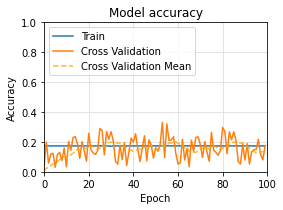

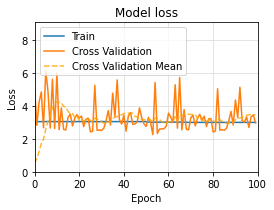

In [26]:
plot_history(history, file=True)

### Predicción

In [27]:
predictor = tf.keras.models.load_model('./best.hdf5')
predictor.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lc (InputLayer)                [(None, 1, 88)]      0           []                               
                                                                                                  
 conv1d_112 (Conv1D)            (None, 1, 128)       22656       ['lc[0][0]']                     
                                                                                                  
 activation_108 (Activation)    (None, 1, 128)       0           ['conv1d_112[0][0]']             
                                                                                                  
 activation_109 (Activation)    (None, 1, 128)       0           ['conv1d_112[0][0]']             
                                                                                            

 multiply_60 (Multiply)         (None, 1, 128)       0           ['activation_120[0][0]',         
                                                                  'activation_121[0][0]']         
                                                                                                  
 conv1d_126 (Conv1D)            (None, 1, 1)         129         ['multiply_60[0][0]']            
                                                                                                  
 add_103 (Add)                  (None, 1, 128)       0           ['add_102[0][0]',                
                                                                  'conv1d_126[0][0]']             
                                                                                                  
 activation_122 (Activation)    (None, 1, 128)       0           ['add_103[0][0]']                
                                                                                                  
 activatio

                                                                                                  
 conv1d_139 (Conv1D)            (None, 757, 1)       129         ['multiply_66[0][0]']            
                                                                                                  
 add_110 (Add)                  (None, 757, 128)     0           ['conv1d_137[0][0]',             
                                                                  'conv1d_139[0][0]']             
                                                                                                  
 conv1d_140 (Conv1D)            (None, 757, 128)     32896       ['add_110[0][0]']                
                                                                                                  
 add_111 (Add)                  (None, 757, 128)     0           ['conv1d_140[0][0]',             
                                                                  'add_108[0][0]']                
          

 multiply_71 (Multiply)         (None, 757, 128)     0           ['activation_142[0][0]',         
                                                                  'activation_143[0][0]']         
                                                                                                  
 conv1d_149 (Conv1D)            (None, 757, 1)       129         ['multiply_71[0][0]']            
                                                                                                  
 add_120 (Add)                  (None, 757, 128)     0           ['add_118[0][0]',                
                                                                  'conv1d_149[0][0]']             
                                                                                                  
 conv1d_150 (Conv1D)            (None, 757, 128)     32896       ['add_120[0][0]']                
                                                                                                  
 add_121 (

 activation_153 (Activation)    (None, 757, 128)     0           ['add_129[0][0]']                
                                                                                                  
 multiply_76 (Multiply)         (None, 757, 128)     0           ['activation_152[0][0]',         
                                                                  'activation_153[0][0]']         
                                                                                                  
 conv1d_159 (Conv1D)            (None, 757, 1)       129         ['multiply_76[0][0]']            
                                                                                                  
 add_130 (Add)                  (None, 757, 128)     0           ['add_128[0][0]',                
                                                                  'conv1d_159[0][0]']             
                                                                                                  
 conv1d_16

 activation_162 (Activation)    (None, 757, 128)     0           ['add_139[0][0]']                
                                                                                                  
 activation_163 (Activation)    (None, 757, 128)     0           ['add_139[0][0]']                
                                                                                                  
 multiply_81 (Multiply)         (None, 757, 128)     0           ['activation_162[0][0]',         
                                                                  'activation_163[0][0]']         
                                                                                                  
 conv1d_169 (Conv1D)            (None, 757, 1)       129         ['multiply_81[0][0]']            
                                                                                                  
 add_140 (Add)                  (None, 757, 128)     0           ['add_138[0][0]',                
          

                                                                  'add_108[0][0]']                
                                                                                                  
 activation_172 (Activation)    (None, 757, 128)     0           ['add_149[0][0]']                
                                                                                                  
 activation_173 (Activation)    (None, 757, 128)     0           ['add_149[0][0]']                
                                                                                                  
 multiply_86 (Multiply)         (None, 757, 128)     0           ['activation_172[0][0]',         
                                                                  'activation_173[0][0]']         
                                                                                                  
 conv1d_179 (Conv1D)            (None, 757, 1)       129         ['multiply_86[0][0]']            
          

                                                                                                  
 add_159 (Add)                  (None, 757, 128)     0           ['conv1d_188[0][0]',             
                                                                  'add_108[0][0]']                
                                                                                                  
 activation_182 (Activation)    (None, 757, 128)     0           ['add_159[0][0]']                
                                                                                                  
 activation_183 (Activation)    (None, 757, 128)     0           ['add_159[0][0]']                
                                                                                                  
 multiply_91 (Multiply)         (None, 757, 128)     0           ['activation_182[0][0]',         
                                                                  'activation_183[0][0]']         
          

                                                                                                  
 conv1d_198 (Conv1D)            (None, 757, 128)     32896       ['add_168[0][0]']                
                                                                                                  
 add_169 (Add)                  (None, 757, 128)     0           ['conv1d_198[0][0]',             
                                                                  'add_108[0][0]']                
                                                                                                  
 activation_192 (Activation)    (None, 757, 128)     0           ['add_169[0][0]']                
                                                                                                  
 activation_193 (Activation)    (None, 757, 128)     0           ['add_169[0][0]']                
                                                                                                  
 multiply_

 add_178 (Add)                  (None, 757, 128)     0           ['add_176[0][0]',                
                                                                  'conv1d_207[0][0]']             
                                                                                                  
 conv1d_208 (Conv1D)            (None, 757, 128)     32896       ['add_178[0][0]']                
                                                                                                  
 add_179 (Add)                  (None, 757, 128)     0           ['conv1d_208[0][0]',             
                                                                  'add_108[0][0]']                
                                                                                                  
 activation_202 (Activation)    (None, 757, 128)     0           ['add_179[0][0]']                
                                                                                                  
 activatio

 conv1d_217 (Conv1D)            (None, 757, 1)       129         ['multiply_105[0][0]']           
                                                                                                  
 add_188 (Add)                  (None, 757, 128)     0           ['add_186[0][0]',                
                                                                  'conv1d_217[0][0]']             
                                                                                                  
 conv1d_218 (Conv1D)            (None, 757, 128)     32896       ['add_188[0][0]']                
                                                                                                  
 add_189 (Add)                  (None, 757, 128)     0           ['conv1d_218[0][0]',             
                                                                  'add_108[0][0]']                
                                                                                                  
 activatio

 re_lu_3 (ReLU)                 (None, 757, 1)       0           ['conv1d_222[0][0]']             
                                                                                                  
 conv1d_223 (Conv1D)            (None, 757, 128)     256         ['re_lu_3[0][0]']                
                                                                                                  
 softmax_1 (Softmax)            (None, 757, 128)     0           ['conv1d_223[0][0]']             
                                                                                                  
Total params: 1,444,408
Trainable params: 1,444,408
Non-trainable params: 0
__________________________________________________________________________________________________


In [29]:
'''
    Función para la generación de todas las predicciones consecutivas que generarían una interpretación.
'''
def predict_wav(in_file, out_file, dir_path, predictor, sr=SAMPLING_RATE, inp_shape=INP_SHAPE, enc=mulaw_enc):

    pianoroll = (midi_hdlr.vectorize_midi(in_file) - MIDI_MIN) / (MIDI_MAX - MIDI_MIN)
    
    # Listas empleadas para el input/output del predictor
    in_arr = tf.random.uniform((INP_SHAPE[0], 1), minval=0, maxval=N_LEVELS, dtype=tf.dtypes.int32)
    in_arr = tf.keras.utils.to_categorical(in_arr, num_classes=N_LEVELS)
    lc_arr = []
    
    # Lista empleada para el output al fichero .wav
    wav_arr = tf.zeros([inp_shape[0]])
    
    for i in tqdm(range(len(pianoroll))):
        
        # Getting the local conditioninng value for this step
        lc_arr = pianoroll[i]
        
        # Getting the value of the prediction
        prediction = predictor.predict({"seq": tf.expand_dims(in_arr, 0), \
                                        "lc": tf.expand_dims(tf.expand_dims(lc_arr, 0), 0)})
        prediction_idx = np.argmax(prediction[0][-1])
        
        # Figuring out the params for prediction in next step
        in_arr = tf.concat([in_arr[1:], tf.expand_dims(tf.keras.utils.to_categorical(prediction_idx, num_classes=N_LEVELS), 0)], 0)
        
        # Storing predicted values in wav format
        wav_arr = tf.concat([wav_arr, [enc.decode_sample(prediction_idx)]], 0)
        
    # Writting predicted series to file
    sf.write(dir_path + '/' + out_file, wav_arr, sr, 'PCM_24')
    
    return wav_arr


In [30]:
midi_hdlr = Midi_handler(sampling_rate=SAMPLING_RATE, dir_path=PATH, n_notes=N_NOTES)
in_file = df['midi_filename'][0]
out_file = 'prediction.wav'
dir_path = './i:o'

In [ ]:
wav_arr = predict_wav(in_file, out_file, dir_path, predictor)

100%|██████████| 20000/20000 [17:56<00:00, 18.58it/s]


In [ ]:
wav_arr[0:100]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>